In [4]:
# import libraries
import pandas as pd # Import Pandas for data manipulation using dataframes
from sklearn.model_selection import train_test_split
import numpy as np # Import Numpy for data statistical analysis 
import matplotlib.pyplot as plt # Import matplotlib for data visualisation
import random
import sqlite3

In [5]:
# Load data

def DB_Connection(db_name):
    ''' Returns a Database connection'''
    conn = sqlite3.connect(db_name)
    print("Connection to DB successfully")
    return conn


# Connect to database 
db_conn = DB_Connection('../db.sqlite3')
cursor = db_conn.cursor()

# List of all tables in the database
for row in cursor.execute("SELECT name FROM sqlite_master WHERE type='table';"):
    print(row)

complete_data_l = pd.read_sql_query("SELECT * FROM hmnist_28_28_L", db_conn)

Connection to DB successfully
('django_migrations',)
('sqlite_sequence',)
('auth_group_permissions',)
('auth_user_groups',)
('auth_user_user_permissions',)
('django_admin_log',)
('django_content_type',)
('auth_permission',)
('auth_group',)
('auth_user',)
('django_session',)
('hmnist_28_28_L',)
('detection_system_img',)
('detection_system_image',)


In [21]:
complete_data_l.shape

(10015, 785)

In [6]:
# Sanity check
# Print head of L dataset
complete_data_l.head()


,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel0775,pixel0776,pixel0777,pixel0778,pixel0779,pixel0780,pixel0781,pixel0782,pixel0783,label
0,169,171,170,177,181,182,181,185,194,192,...,184,186,185,180,157,140,140,159,165,2
1,19,57,105,140,149,148,144,155,170,170,...,172,175,160,144,114,89,47,18,18,2
2,155,163,161,167,167,172,155,152,165,175,...,163,178,157,166,167,148,141,136,115,2
3,25,71,116,139,136,153,148,161,172,162,...,125,135,138,137,111,71,32,16,16,2
4,129,162,181,196,205,208,205,213,225,224,...,210,197,172,190,195,193,181,147,88,2


In [31]:
# Print shape of both datasets
print(complete_data_l[:1].shape)

(1, 785)


In [8]:
#Split data set into train, test and validate sets
# Define percentage for training-set
train_split = 0.8
# Define percentage for test-set
test_split = 0.05
# Split the set percentage into training_df and the rest into dummy_df
train_df, dummy_df = train_test_split(complete_data_l, train_size=train_split, shuffle=True, random_state=123)
# 
dummy_split = test_split/(1.0 - train_split)
# Split dummy into test and validation dataframes
test_df, valid_df = train_test_split(dummy_df, train_size = dummy_split)

# Transform dataframes into arrays
training = np.array(train_df, dtype='float32')
testing = np.array(test_df, dtype='float32')
validating = np.array(valid_df, dtype = 'float32')

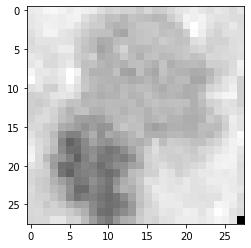

In [9]:
# Show image
i = random.randint(1, 1000)
plt.imshow(training[i, 1:].reshape((28,28)), cmap='gray')


In [10]:
# Extract label for the current DatasetImage
label = training[i, -1]
label

#Label directory
# 0 = akies
# 1 = bcc
# 2 = bkl
# 3 = df
# 4 = mel
# 5 = nv
# 6 = vascs (multiple)

4.0

In [11]:
# Prepare the datasets, divide by 255 to get value between 0-1
X_train = training[:,:-1]/255
# Extract labels
y_train = training[:, -1]

X_test = testing[:,:-1]/255
# Extract labels
y_test = testing[:, -1]

In [33]:
# Reshape the data for the CNN model
X_train = X_train.reshape(X_train.shape[0], * (28, 28, 1))
X_test = X_test.reshape(X_test.shape[0], * (28, 28, 1))

X_train[:1].shape

(1, 28, 28, 1)

In [13]:
# Import libraries
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import TensorBoard

In [14]:
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape=(28, 28, 1)))

model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Conv2D(64, (3, 3), activation = 'relu'))

model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(64, activation = 'relu'))

model.add(keras.layers.Dense(32, activation = 'relu'))

model.add(keras.layers.Dense(16, activation = 'relu'))

model.add(keras.layers.Dense(7, activation = "softmax"))

model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

history = model.fit(X_train,y_train, epochs=1,validation_data=(X_test,y_test), batch_size = 1)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                102464    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2

/home/linus/anaconda3/lib/python3.8/site-packages/keras/backend.py:4906: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


8012/8012 [==============================] - 32s 4ms/step - loss: 1.1043 - accuracy: 0.6706 - val_loss: 1.0536 - val_accuracy: 0.6620


In [16]:
model.save('mock_model.h5')